In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import networkx as nx
import random
import matplotlib.pyplot as plt
import sys
import os
import json
import numpy as np
import pandas as pd

In [2]:
def generate_random_connected_graph(num_nodes, background_density, background_weight, return_flexible_edges = False):
    tree_base = nx.random_tree(n = num_nodes)
    G = tree_base
    
    num_edges_to_add = int(num_nodes*(num_nodes - 1)*0.5*background_density - (num_nodes - 1))
    #pick num_edges_to_add random edges to add to G
    flexible_edge_list = random.sample(list(nx.non_edges(G)), num_edges_to_add)
    G.add_edges_from(flexible_edge_list)
    nx.set_edge_attributes(G, values = background_weight, name = 'weight')
    
    assert(nx.is_connected(G)) 
    if (return_flexible_edges): 
        return (G, flexible_edge_list)
    else:
        return G

In [3]:
def find_paths(G, source_node, length, excludeSet = None):
    if excludeSet == None:
        excludeSet = set([source_node])
    else:
        excludeSet.add(source_node)
    if length==0:
        return [[source_node]]
    paths = [[source_node] + path for neighbor in G.neighbors(source_node) if neighbor not in excludeSet for path in find_paths(G,neighbor,length-1,excludeSet)]
    excludeSet.remove(source_node)
    return paths


In [4]:
#utility functions

def choose_S_path(G, num_S):
    all_candidates = []
    for node in G:
        all_candidates.extend(find_paths(G, node, num_S-1))
    result = random.choice(all_candidates)
    return result

def path_compare(path1, path2):
    assert( len(path1) == len(path2) )
    for c1, c2 in zip(path1, path2):
        if (c1 != c2):
            return False
    return True


In [5]:
def construct_test_case(G_num_nodes, G_density, G_background_weight, S_num_nodes, S_weight):
    G1 = generate_random_connected_graph(G_num_nodes, G_density, G_background_weight)
    G2, flexible_edges = generate_random_connected_graph(G_num_nodes, G_density, G_background_weight, return_flexible_edges = True)
    
    S = choose_S_path(G1, S_num_nodes)
    S_path_graph = nx.path_graph(S)
    
    filtered_edges = []
    for (a,b) in flexible_edges:
        if (a,b) in S_path_graph.edges():
            pass
        else:
            filtered_edges.append((a,b))
    flexible_edges= filtered_edges
    
    weight_dict = {e:S_weight for e in S_path_graph.edges()}
    for u, v in S_path_graph.edges():
        G1[u][v]['weight'] = S_weight 
        if ((u,v) not in G2.edges()):
            G2.add_edge(u, v)
            (a,b) = random.choice(flexible_edges)
            G2.remove_edge(a,b)
            flexible_edges.remove((a,b))
            G2[u][v]['weight'] = S_weight
    
    return (G1, G2, S)

In [15]:
def run_ctd_docker(adj_matrix_path, S_string):
    out_path = adj_matrix_path.rstrip('csv') + 'json'
    cwd = os.getcwd()
    ctd_run_command = "docker run -v {}:/mnt vladimirkovacevic/ctd:1.6 Rscript /opt/CTD/R/CTD.r --adj_matrix /mnt/{} --disease_module {} --output_name /mnt/{}".format(cwd, adj_matrix_path, S_string, out_path)
    os.system(ctd_run_command)

In [20]:


def write_test_case_to_CTD2_input_files(G1, G2, S, adj_fname_G1_path='adj_G1.csv', adj_fname_G2_path='adj_G2.csv', S_path='S.csv'):

    S_string = '\n'.join([str(item) for item in S])
    with open(S_path, 'w') as f:
        f.write("S module\n"+S_string)

    adj_G1 = nx.to_pandas_adjacency(G1)
    adj_G2 = nx.to_pandas_adjacency(G2)

    adj_G1.to_csv(path_or_buf=adj_fname_G1_path,index=False)
    adj_G2.to_csv(path_or_buf=adj_fname_G2_path,index=False)



In [61]:
def calculate_bonferroni_pvalue(path_G1_adjacency='adj_G1.csv', path_G2_adjacency='adj_G2.csv', path_S='S.csv'):
    
    df = pd.read_csv(path_S)
    #print(len(df.iloc[:,-1].values))
    S_string = ','.join(list(df.iloc[:,-1].astype(str).values))
    
    run_ctd_docker(path_G1_adjacency, S_string)
    run_ctd_docker(path_G2_adjacency, S_string)

    json_G1 = path_G1_adjacency.rstrip('csv') + 'json'
    json_G2 = path_G2_adjacency.rstrip('csv') + 'json'

    # Loading with json.load directly from file can cause problems on Windows, so load the contents to a string first, then call loads
    # Another way to prevent this problem is to save the file as .txt instead of .json
    # Beauty of Windows...
    with open(json_G1, 'r') as json_file1, open(json_G2, 'r') as json_file2:
        contents = json_file2.read()
        data = json.loads(contents)
        pval2 = data['p_value']
        print(f"pval2:{pval2}")

        contents = json_file1.read()
        data = json.loads(contents)
        not_found = len(data['S_perturbed_nodes']) - len(data['optimal_bitstring'])
        power = not_found * np.log(len(G1.nodes())) + len(data['optimal_bitstring'])
        probability_S_in_G1 = np.power(2, -power)
        print(f"probability of S in G1:{probability_S_in_G1}")

    pval_bonf = pval2 / probability_S_in_G1
    return pval_bonf

In [64]:
(G1, G2, S) = construct_test_case(G_num_nodes=50, G_density=0.2, G_background_weight=0.1, S_num_nodes=6, S_weight=2)
write_test_case_to_CTD2_input_files(G1, G2, S)

print(calculate_bonferroni_pvalue())

pval2:4.09679772828667e-07
probability of S in G1:0.015625
2.621950546103469e-05


In [ ]:
G_num_nodes_values = [100, 1000, 10000, 100000]
G_density = [0.1*i for i in range(10)]
weight_ratio = [2, 5, 10]
node_number_ration = [0.01, 0.05, 0.1]

In [ ]:
#     for idx, it in enumerate(list(itertools.product(*[max_depth, learning_rate, n_estimators, booster, min_child_weight,
#                                                       gamma,subsample,colsample_bytree, scale_pos_weights]))):
#         models[':'.join(['XGBClassifier'] + [str(ii) for ii in it])] = XGBClassifier(
#             max_depth=it[0], learning_rate=it[1], n_estimators=it[2], booster=it[3],
#             min_child_weight=it[4], gamma=it[5], subsample=it[6], colsample_bytree=it[7],

G:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
G:\Anaconda\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


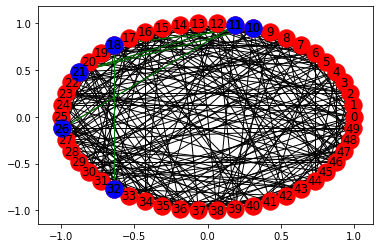

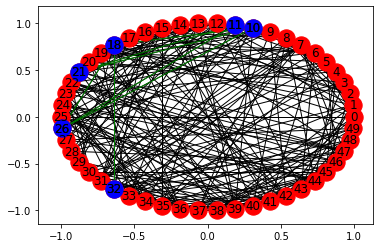

In [65]:
edge_weights = nx.get_edge_attributes(G1,'weight')

pos=nx.circular_layout(G1)
nx.draw_networkx(G1, pos=pos)
nx.draw_networkx(nx.induced_subgraph(G1, S), pos=pos, node_color = 'blue', edge_color = 'green')
#nx.draw_networkx_edge_labels(G1, pos, edge_labels = edge_weights)
plt.show()

pos=nx.circular_layout(G2)
nx.draw_networkx(G2, pos=pos)
nx.draw_networkx(nx.induced_subgraph(G2, S), pos=pos, node_color = 'blue', edge_color = 'green')
#nx.draw_networkx_edge_labels(G2, pos, edge_labels = edge_weights)
plt.show()